## Load packages

In [43]:
import warnings
warnings.filterwarnings('ignore')
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import sklearn.linear_model as slm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from brainspace.utils.parcellation import map_to_labels
import cmasher as cmr
from neuroCombat import neuroCombat
from matplotlib import cm
from sklearn.metrics import mean_absolute_error as mae
import func_utils as fu

In [44]:
# change pattern, l1_ratio should be the float not postion
pattern = 'intra'; l1=0.1

## Prepare features

In [45]:
df = pd.read_csv('../abide_demo_sort.csv')
site = np.array(df['site'])
site[site=='NYU'] = 1.
site[site=='Pitt'] = 2.
site[site=='USM'] = 3.
site[site=='NYU_II'] = 4.
site[site=='TCD'] = 5.
df['site'] = site
df['site'] = pd.to_numeric(df['site'])
df['ados'] = df['ados_comm'] + df['ados_rrb'] + df['ados_social']
df

,ID,group,site,age,FIQ,ados_comm,ados_social,ados_rrb,meanFD,ados
0,29096,ASD,5.0,15.50,98,2,5,0,0.165400,7
1,29099,ASD,5.0,10.75,123,3,5,0,0.148400,8
2,29101,ASD,5.0,14.00,103,3,4,0,0.248200,7
3,29103,ASD,5.0,14.75,108,4,3,0,0.161700,7
4,29104,ASD,5.0,19.25,119,3,13,1,0.066200,17
...,...,...,...,...,...,...,...,...,...,...
278,32641,ASD,3.0,18.25,106,4,9,1,0.175961,14
279,32643,ASD,3.0,16.92,84,1,11,0,0.122636,12
280,32646,ASD,3.0,20.17,108,3,5,0,0.062141,8
281,32647,ASD,3.0,32.55,126,4,6,0,0.121629,10


In [46]:
def harmony(data):
    data_combat = neuroCombat(dat=data.T, mean_only= True,
                              covars=cov,
                              batch_col='site',
                              continuous_cols=['age'])['data']
    return data_combat.T

In [47]:
id = np.array(df['ID'][df['group']=='ASD'])
ados = np.array(df['ados'][df['group']=='ASD'])
ados_comm = np.array(df['ados_comm'][df['group']=='ASD'])
ados_social = np.array(df['ados_social'][df['group']=='ASD'])
ados_rrb = np.array(df['ados_rrb'][df['group']=='ASD'])
age = np.array(df['age'][df['group']=='ASD'])
site = np.array(df['site'][df['group']=='ASD'])

id = id[ados_comm != -999]
ados = ados[ados_comm != -999]
ados_social = ados_social[ados_comm != -999]
ados_rrb = ados_rrb[ados_comm != -999]
site = site[ados_comm != -999]
age = age[ados_comm != -999]
ados_comm = ados_comm[ados_comm != -999]
cov = pd.DataFrame()
cov['site'] = site
cov['age'] = age
cov

,site,age
0,5.0,15.50
1,5.0,10.75
2,5.0,14.00
3,5.0,14.75
4,5.0,19.25
...,...,...
127,3.0,18.25
128,3.0,16.92
129,3.0,20.17
130,3.0,32.55


In [48]:
feature = [None] * len(id)
for i in range(len(id)):
  feature[i] = np.genfromtxt('../results/grad/'+pattern+'/'+str(id[i])+'.csv', 
                             delimiter=',')[:,:3]

In [49]:
x = np.concatenate((np.array(feature).T[0],np.array(feature).T[1], np.array(feature).T[2])).T
x = harmony(x)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [50]:
ados.max(), ados.min(), ados.argmax(), ados.argmin()

(29, 5, 93, 30)

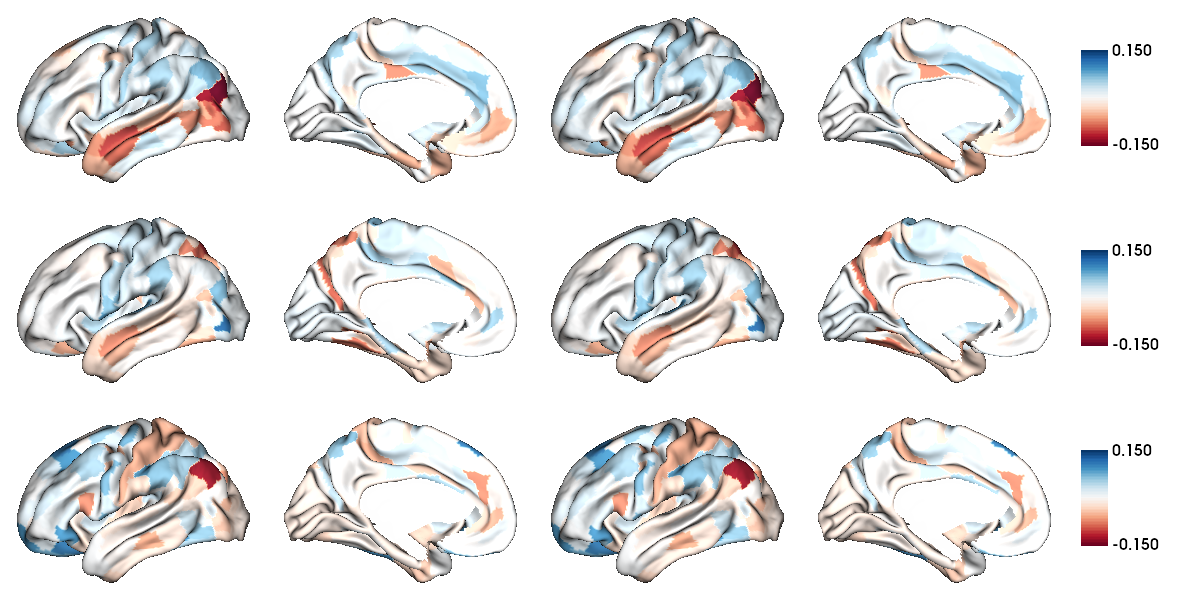

In [51]:
mask = fu.mmp_ll != 0
plot = [None] * 3
for i in range(3):
  plot[i] = map_to_labels(np.concatenate((x[ados.argmax()][180*i:180*(i+1)],x[ados.argmax()][180*i:180*(i+1)])), 
                          fu.mmp_ll, mask=mask)
  plot[i][plot[i]==0]=np.nan

fu.plot_surface_ll(data=plot, size=(1200,600), cmap='RdBu', color_range=(-0.15, 0.15), 
                   filename='../figures/pred_feature_ados_max_'+pattern+'.png')

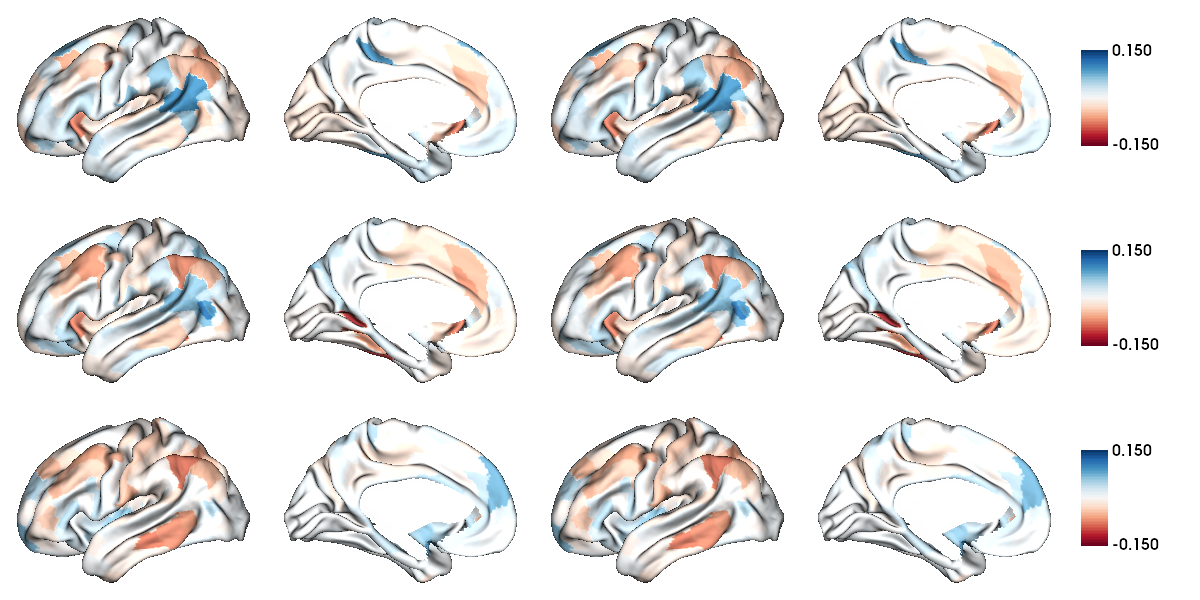

In [52]:
plot = [None] * 3
for i in range(3):
  plot[i] = map_to_labels(np.concatenate((x[ados.argmin()][180*i:180*(i+1)],x[ados.argmin()][180*i:180*(i+1)])), 
                          fu.mmp_ll, mask=mask)
  plot[i][plot[i]==0]=np.nan

fu.plot_surface_ll(data=plot, size=(1200,600), cmap='RdBu', color_range=(-0.15, 0.15), 
                   filename='../figures/pred_feature_ados_min_'+pattern+'.png')

## Elastic with CV

In [53]:
lr = slm.ElasticNetCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], l1_ratio=l1, cv=5)
sfs1 = lr.fit(x, ados)

In [54]:
rp = ss.pearsonr(ados, sfs1.predict(x))
MAE = mae(ados, sfs1.predict(x))
[rp, MAE]

[(0.8655929825254297, 7.182076094414881e-41), 2.738705727551351]

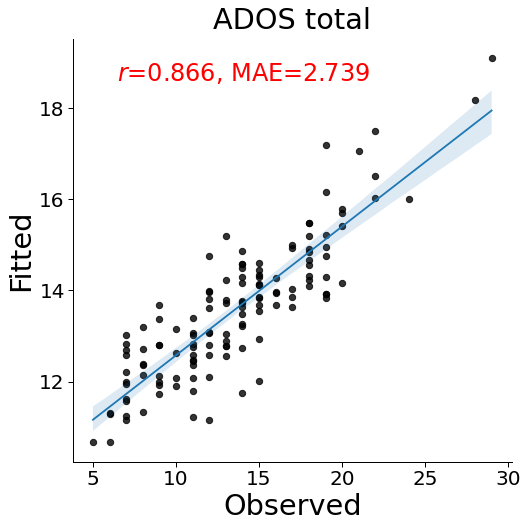

In [55]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(ados, sfs1.predict(x), ax = ax, scatter_kws={'s': 40, 'color': 'black'})
ax.set_title('ADOS total', pad=10)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Observed')
ax.set_ylabel('Fitted')
ax.text(0.1, 0.9, '$\it{r}$=' + '%.3f'%rp[0]+', MAE='+'%.3f'%MAE, fontsize=24, c='red', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/EN_cv_predict_'+pattern+'.png', dpi=300, transparent=True)

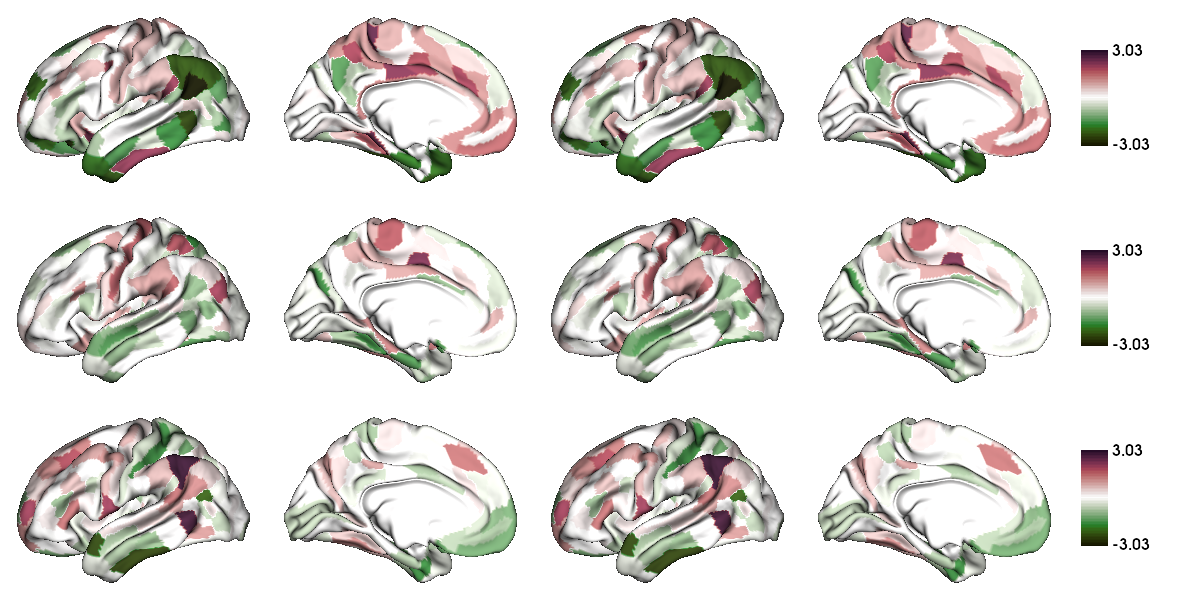

In [56]:
mask = fu.mmp_ll != 0
select_model=sfs1.coef_.copy()
plot_select = [select_model[:180],select_model[180:360], select_model[360:]]
plot = [None] * 3
for i in range(3):
  plot[i] = map_to_labels(np.concatenate((plot_select[i],plot_select[i])), fu.mmp_ll, mask=mask)
  #plot[i][plot[i]==0]=np.nan
max=abs(select_model).max()
fu.plot_surface_ll(data=plot, size=(1200,600), cmap=cmr.holly, color_range=(-max, max), 
                   filename='../figures/EN_cv_'+pattern+'.png')

In [57]:
ca_select = np.zeros((12,3))
for i in range(3):
  for j in range(12):
    ca_select[j,i] = abs(plot_select[i][fu.ca[:180]==j+1]).mean()
ca_select

array([[0.03311846, 0.40477293, 0.61541737],
       [0.46942867, 0.66403348, 0.42628756],
       [0.54770862, 0.60922658, 0.47617122],
       [0.69455796, 0.6159452 , 0.39161165],
       [0.95855854, 0.8812326 , 0.45615651],
       [0.56020679, 0.66971961, 0.77740384],
       [0.73422208, 0.25422472, 0.62706721],
       [0.38007499, 0.37310734, 0.15392553],
       [1.03980784, 0.41829241, 0.65320713],
       [1.02115852, 0.5837288 , 0.95804645],
       [0.45312008, 0.2647765 , 1.19419999],
       [1.20510385, 0.90203166, 0.75768317]])

In [58]:
fu.ca_radar_3g(ca_select, 650, filename='../figures/EN_cv_ca_'+pattern)
import time
time.sleep(2)
shutil.copy('../../../../Downloads/plot_image.svg', '../figures/EN_cv_ca_'+pattern+'.svg')
os.remove('../figures/EN_cv_ca_'+pattern+'.html')
os.remove('../../../../Downloads/plot_image.svg')